# Config

In [1]:
import os
from tools.utils import *

In [2]:
# import conversion tools
from tools.conv_tools import *
from tools import conv_tools
ctools = get_funs_from_module(conv_tools)
ctools.keys()

dict_keys(['PyPDF4_ocr', 'dbg', 'emb_text_is_usable', 'extract_text', 'get_child_dir_paths', 'get_child_ext_path', 'get_emb_txt', 'get_funs_from_module', 'get_langs', 'get_metadata', 'get_parent_dir', 'get_var_name', 'getmembers', 'grobid_extr', 'img2pdf', 'in_lang_sc', 'in_lang_wl', 'isfunction', 'join_parentpath_childnames', 'list_ext', 'mv_to_custom_dir', 'pdf2img', 'pdf2txt', 'pdf2xml', 'pdfminer_ocr', 'pdfreader_ocr', 'prep_and_tokenise', 'pytesseract_ocr', 'read_doc_metadata', 'tika_ocr', 'translate_wl', 'true_counter', 'words_in_lang_ratio', 'words_in_langs_ratio', 'write_pdf_metadata'])

In [3]:
from tools import eval_tools
etools = get_funs_from_module(eval_tools)
etools.keys()

dict_keys(['dbg', 'emb_text_is_usable', 'eval_tools_scores', 'get_child_dir_paths', 'get_child_ext_path', 'get_emb_txt', 'get_funs_from_module', 'get_langs', 'get_metadata', 'get_parent_dir', 'get_var_name', 'getmembers', 'in_lang_sc', 'in_lang_wl', 'isfunction', 'join_parentpath_childnames', 'list_ext', 'mv_to_custom_dir', 'prep_and_tokenise', 'read_doc_metadata', 'spellcheck_score', 'translate_wl', 'true_counter', 'word_is_correct_Q', 'words_in_lang_ratio', 'words_in_langs_ratio', 'write_pdf_metadata'])

# Load and Rearrange Files

In [4]:
from tools.utils import *

In [5]:
data_path = os.path.join('data')

input_dir_path = os.path.join(data_path, 'docs_for_eval')

selected_conv_tools = ['PyPDF4_ocr',    # names of the tools for conversion
                    'extract_text',
                    'pdfminer_ocr',
                    'pdfreader_ocr',
                    'pytesseract_ocr',
                    'tika_ocr',  
                    ]
selected_scores = ['spellcheck_score',  # names of the scores for tool evaluation
                    ]
score_data_dirpath = 'evaluation_results'
score_data_filepath = os.path.join(score_data_dirpath,'scores')

doc_paths = [os.path.join(input_dir_path, filepath) for filepath in os.listdir(input_dir_path) if os.path.isfile(os.path.join(input_dir_path, filepath))]


In [6]:
%%capture
# if there are any imgs, convert them to pdf
not_pdf_filepaths = list_ext(input_dir_path,    # files to be converted to pdf
                            exts=['pdf'],
                            invert=True)

for not_pdf_filepath in not_pdf_filepaths:
    ctools['img2pdf']([not_pdf_filepath])

pdf_filepaths = list_ext(input_dir_path,        # all pdf files
                        exts=['pdf'],
                        invert=False)

In [7]:
# rearrange folder structure
for pdf_filepath in pdf_filepaths:
    mv_to_custom_dir(pdf_filepath)
for not_pdf_filepath in not_pdf_filepaths:
    os.remove(not_pdf_filepath)

In [8]:
%%capture
# compile metadata for each file
for dir_path in get_child_dir_paths(input_dir_path):
    metadata = write_pdf_metadata(path=dir_path)

# Conversion

In [9]:
from tools.conv_tools import *

In [10]:
dir_paths = get_child_dir_paths(input_dir_path)
for dir_path in dir_paths:  
    dbg(dir_path)
    pdf2txt(doc_dir_path=dir_path,
            tool_names=selected_conv_tools,
            tools=ctools,
            overwrite=True,
            )

dir_path: data/docs_for_eval/2018_Warabieda_Cacopsylla_pruni_Pologne_copie--page0
tool: <function PyPDF4_ocr at 0x7f9e6ae553f0>
mess: 0.pdf
tool: <function extract_text at 0x7f9e6bddff40>
mess: 0.pdf
tool: <function pdfminer_ocr at 0x7f9e6ae55480>
mess: 0.pdf
tool: <function pdfreader_ocr at 0x7f9e6ae555a0>
mess: 0.pdf
tool: <function pytesseract_ocr at 0x7f9e6ae54700>
mess: 0.pdf


2022-05-17 08:54:20,978 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.
INFO:tika.tika:Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.


tool: <function tika_ocr at 0x7f9e6ae55510>
mess: 0.pdf


# Evaluation

In [ ]:
from tools.eval_tools import eval_tools_scores

In [ ]:
scores_results = eval_tools_scores(db_dir_path=input_dir_path,
                        conv_tool_names=selected_conv_tools, # tools to be evaluated
                        score_names=selected_scores,
                        scoring_funs=etools,
                        )
scores_results

0it [00:00, ?it/s]


{}

In [ ]:
try:
    os.mkdir(score_data_dirpath)
except FileExistsError:
    print('{0} directory already exists.'.format(score_data_dirpath))
with open(score_data_filepath+'.json', 'w+') as f:
    json.dump(scores_results, f)

evaluation_results directory already exists.


# Visualisation

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
with open(score_data_filepath+'.json', 'r') as f:
    score_results = json.load(f)

In [ ]:
score_name = selected_scores[0]
data = score_results[score_name]

KeyError: 'spellcheck_score'

Text(0, 0.5, 'spellcheck_score')

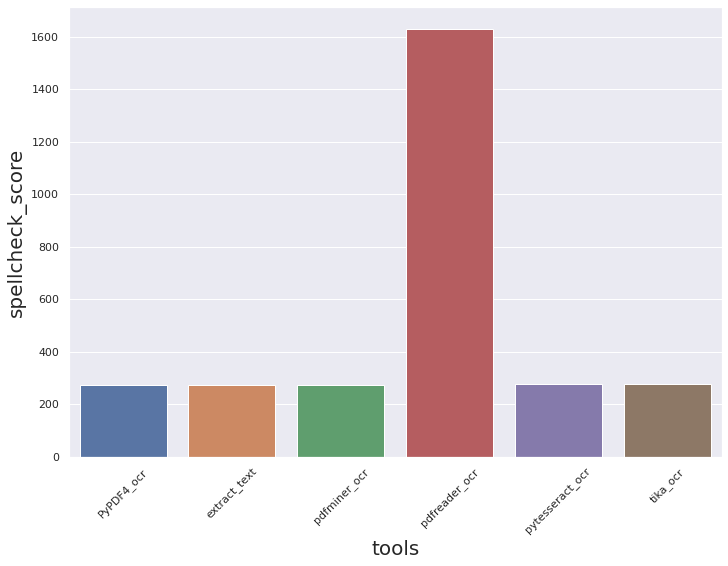

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(rotation=45)
p = sns.barplot(x=list(data.keys()), y=list(data.values()))
p.set_xlabel('tools', fontsize = 20)
p.set_ylabel(score_name, fontsize = 20)

In [ ]:
p.figure.savefig(score_data_filepath+'.png')